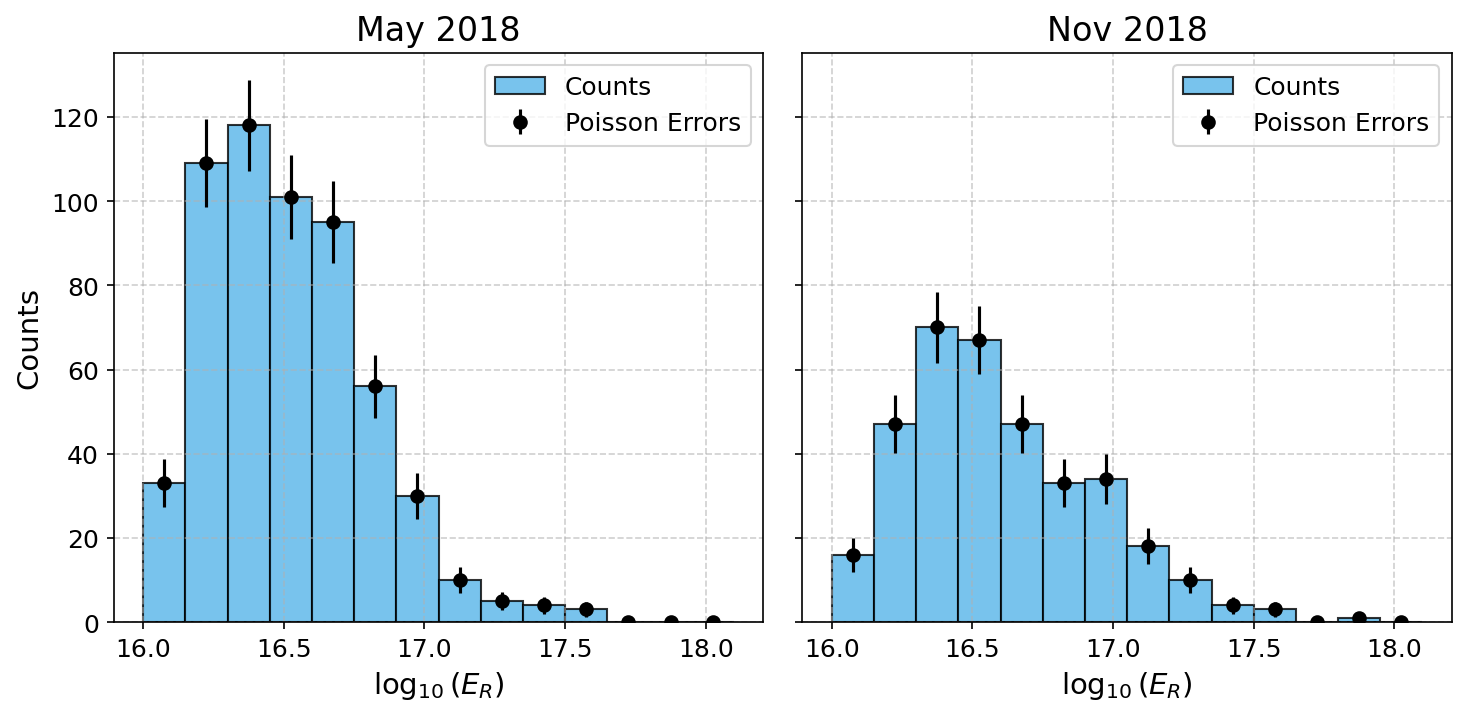

data_2018["May"] = {
    "T_obs": 2104715.00,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([33, 109, 118, 101, 95, 56, 30, 10, 5, 4, 3, 0, 0, 0]),
    "errors": np.array([5.74, 10.44, 10.86, 10.05, 9.75, 7.48, 5.48, 3.16, 2.24, 2.00, 1.73, 0.00, 0.00, 0.00])
}

data_2018["November"] = {
    "T_obs": 9177.00,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([16, 47, 70, 67, 47, 33, 34, 18, 10, 4, 3, 0, 1, 0]),
    "errors": np.array([4.00, 6.86, 8.37, 8.19, 6.86, 5.74, 5.83, 4.24, 3.16, 2.00, 1.73, 0.00, 1.00, 0.00])
}



In [3]:
"""
This script processes LORA (LOFAR Radboud Air Shower Array) event data to reconstruct
primary cosmic ray energy distributions for specific months in 2018.

Workflow:
1. Load a list of filtered event filenames that pass predefined quality cuts.
2. For each selected year-month:
   - Read corresponding `.dat` files and extract event parameters 
     (zenith angle, charged particle number, and energy).
   - Apply cuts (zenith ≤ 35°, positive energy/particle counts).
   - Transform data to log-space: log10(Ne) and log10(E).
   - Fit a linear relation log10(E) = a + b·log10(Ne) using curve fitting.
   - Reconstruct log10(E_R) with uncertainties from fit parameters.
   - Build histograms of reconstructed energy with Poisson error bars.
3. Plot side-by-side histograms for May and November 2018 using 
   colorblind-friendly styling.
4. Print a structured data summary with observation time, bin centers,
   event counts, and statistical errors for further analysis.

Key outputs:
- Visual histograms of reconstructed energies.
- Exportable arrays (bin centers, counts, errors) for later use.
"""
import os
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import calendar
import matplotlib as mpl

def process_lora_data(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        if len(lines) < 2:
            return None

        header = lines[1].strip().split('\t')
        elevation = float(header[4])
        energy = float(header[19])
        charged_particles = float(header[17])

        if energy <= 0 or charged_particles <= 0:
            return None

        return {
            "zenith": 90.0 - elevation,
            "log_Ne": np.log10(charged_particles),
            "log_E": np.log10(energy),
        }
    except (ValueError, IndexError):
        return None

# === Load filtered filenames ===
filtered_event_file = "/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/NuRadioMC/NuRadioReco/LORA/filtered_event_after_Nch_rm_cut.txt"
with open(filtered_event_file, "r") as f:
    filtered_filenames = set(line.strip().split('\t')[0] for line in f.readlines()[1:])  # Skip header

# === Directory with event .dat files ===
data_dir = '/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/lora-datapipeline/Output_all_root_events'

# === Define which year/month to process ===
year_months = [(2018, '05'), (2018, '11')]

for year, month in year_months:
    zenith_list, log_Ne_list, log_E_list = [], [], []
    target_year_month = f"{year}{month}"

    # Loop over filtered events only
    for fname in filtered_filenames:
        if target_year_month in fname:
            file_path = os.path.join(data_dir, fname)
            data = process_lora_data(file_path)
            if data and data["zenith"] <= 35.0:
                zenith_list.append(data["zenith"])
                log_Ne_list.append(data["log_Ne"])
                log_E_list.append(data["log_E"])

    # Convert lists to arrays
    log_Ne_array = np.array(log_Ne_list)
    log_E_array = np.array(log_E_list)

    # Skip empty cases
    if len(log_Ne_array) == 0:
        print(f"No filtered events for {year}-{month} with zenith ≤ 35°")
        continue

    # Fit: log_E = a + b * log_Ne
    def linear_fit(log_Ne, a, b):
        return a + b * log_Ne

    popt, pcov = curve_fit(linear_fit, log_Ne_array, log_E_array)
    a, b = popt
    sigma_a = np.sqrt(pcov[0, 0])
    sigma_b = np.sqrt(pcov[1, 1])

    # Reconstruct energy and error
    log_ER_array = a + b * log_Ne_array
    log_ER_error = np.sqrt(sigma_a**2 + (log_Ne_array ** 2) * sigma_b**2)

    # Histogram
    bin_min = np.floor(min(log_ER_array))
    bin_max = np.ceil(max(log_ER_array))
    bin_width = 0.15
    bin_edges = np.arange(bin_min, bin_max + bin_width, bin_width)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    counts, _ = np.histogram(log_ER_array, bins=bin_edges)
    count_errors = np.sqrt(counts)


# Set high-quality and colorblind-friendly settings
mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 150,
    'figure.figsize': (10, 5),
})

# Colorblind-friendly palette (Color Universal Design)
colors = {
    "bar": "#56B4E9",        # Sky Blue
    "error": "#000000",      # Black for error bars
}

fig, axs = plt.subplots(1, 2, sharey=True)

plot_index = 0
data_summary = {}

for year, month in year_months:
    zenith_list, log_Ne_list, log_E_list = [], [], []
    target_year_month = f"{year}{month}"

    for fname in filtered_filenames:
        if target_year_month in fname:
            file_path = os.path.join(data_dir, fname)
            data = process_lora_data(file_path)
            if data and data["zenith"] <= 35.0:
                zenith_list.append(data["zenith"])
                log_Ne_list.append(data["log_Ne"])
                log_E_list.append(data["log_E"])

    log_Ne_array = np.array(log_Ne_list)
    log_E_array = np.array(log_E_list)

    if len(log_Ne_array) == 0:
        print(f"No filtered events for {year}-{month} with zenith ≤ 35°")
        continue

    def linear_fit(log_Ne, a, b):
        return a + b * log_Ne

    popt, pcov = curve_fit(linear_fit, log_Ne_array, log_E_array)
    a, b = popt
    sigma_a = np.sqrt(pcov[0, 0])
    sigma_b = np.sqrt(pcov[1, 1])

    log_ER_array = a + b * log_Ne_array
    log_ER_error = np.sqrt(sigma_a**2 + (log_Ne_array ** 2) * sigma_b**2)

    bin_min = np.floor(min(log_ER_array))
    bin_max = np.ceil(max(log_ER_array))
    bin_width = 0.15
    bin_edges = np.arange(bin_min, bin_max + bin_width, bin_width)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    counts, _ = np.histogram(log_ER_array, bins=bin_edges)
    count_errors = np.sqrt(counts)

    ax = axs[plot_index]
    ax.bar(bin_centers, counts, width=bin_width, color=colors["bar"], edgecolor='black', alpha=0.8, label='Counts')
    ax.errorbar(bin_centers, counts, yerr=count_errors, fmt='o', color=colors["error"], label='Poisson Errors')
    ax.set_xlabel(r'$\log_{10}(E_R)$')
    if plot_index == 0:
        ax.set_ylabel("Counts")
    ax.grid(True, linestyle='--', alpha=0.6)
    month_name = calendar.month_abbr[int(month)]
    ax.set_title(f"{month_name} {year}")
    ax.legend()

    # Store for summary
    if year == 2018 and month in ['05', '11']:
        T_obs = 2104715.00 if month == '05' else 9177.00
        data_summary[calendar.month_name[int(month)]] = {
            "T_obs": T_obs,
            "bin_centers": bin_centers,
            "counts": counts,
            "errors": count_errors
        }

    plot_index += 1

plt.tight_layout()
plt.show()

# Print data summary
for month_name, data in data_summary.items():
    print(f'data_2018["{month_name}"] = {{')
    print(f'    "T_obs": {data["T_obs"]:.2f},')
    print(f'    "bin_centers": np.array([{", ".join(f"{x:.2f}" for x in data["bin_centers"])}]),')
    print(f'    "counts": np.array([{", ".join(str(int(x)) for x in data["counts"])}]),')
    print(f'    "errors": np.array([{", ".join(f"{x:.2f}" for x in data["errors"])}])')
    print('}\n')


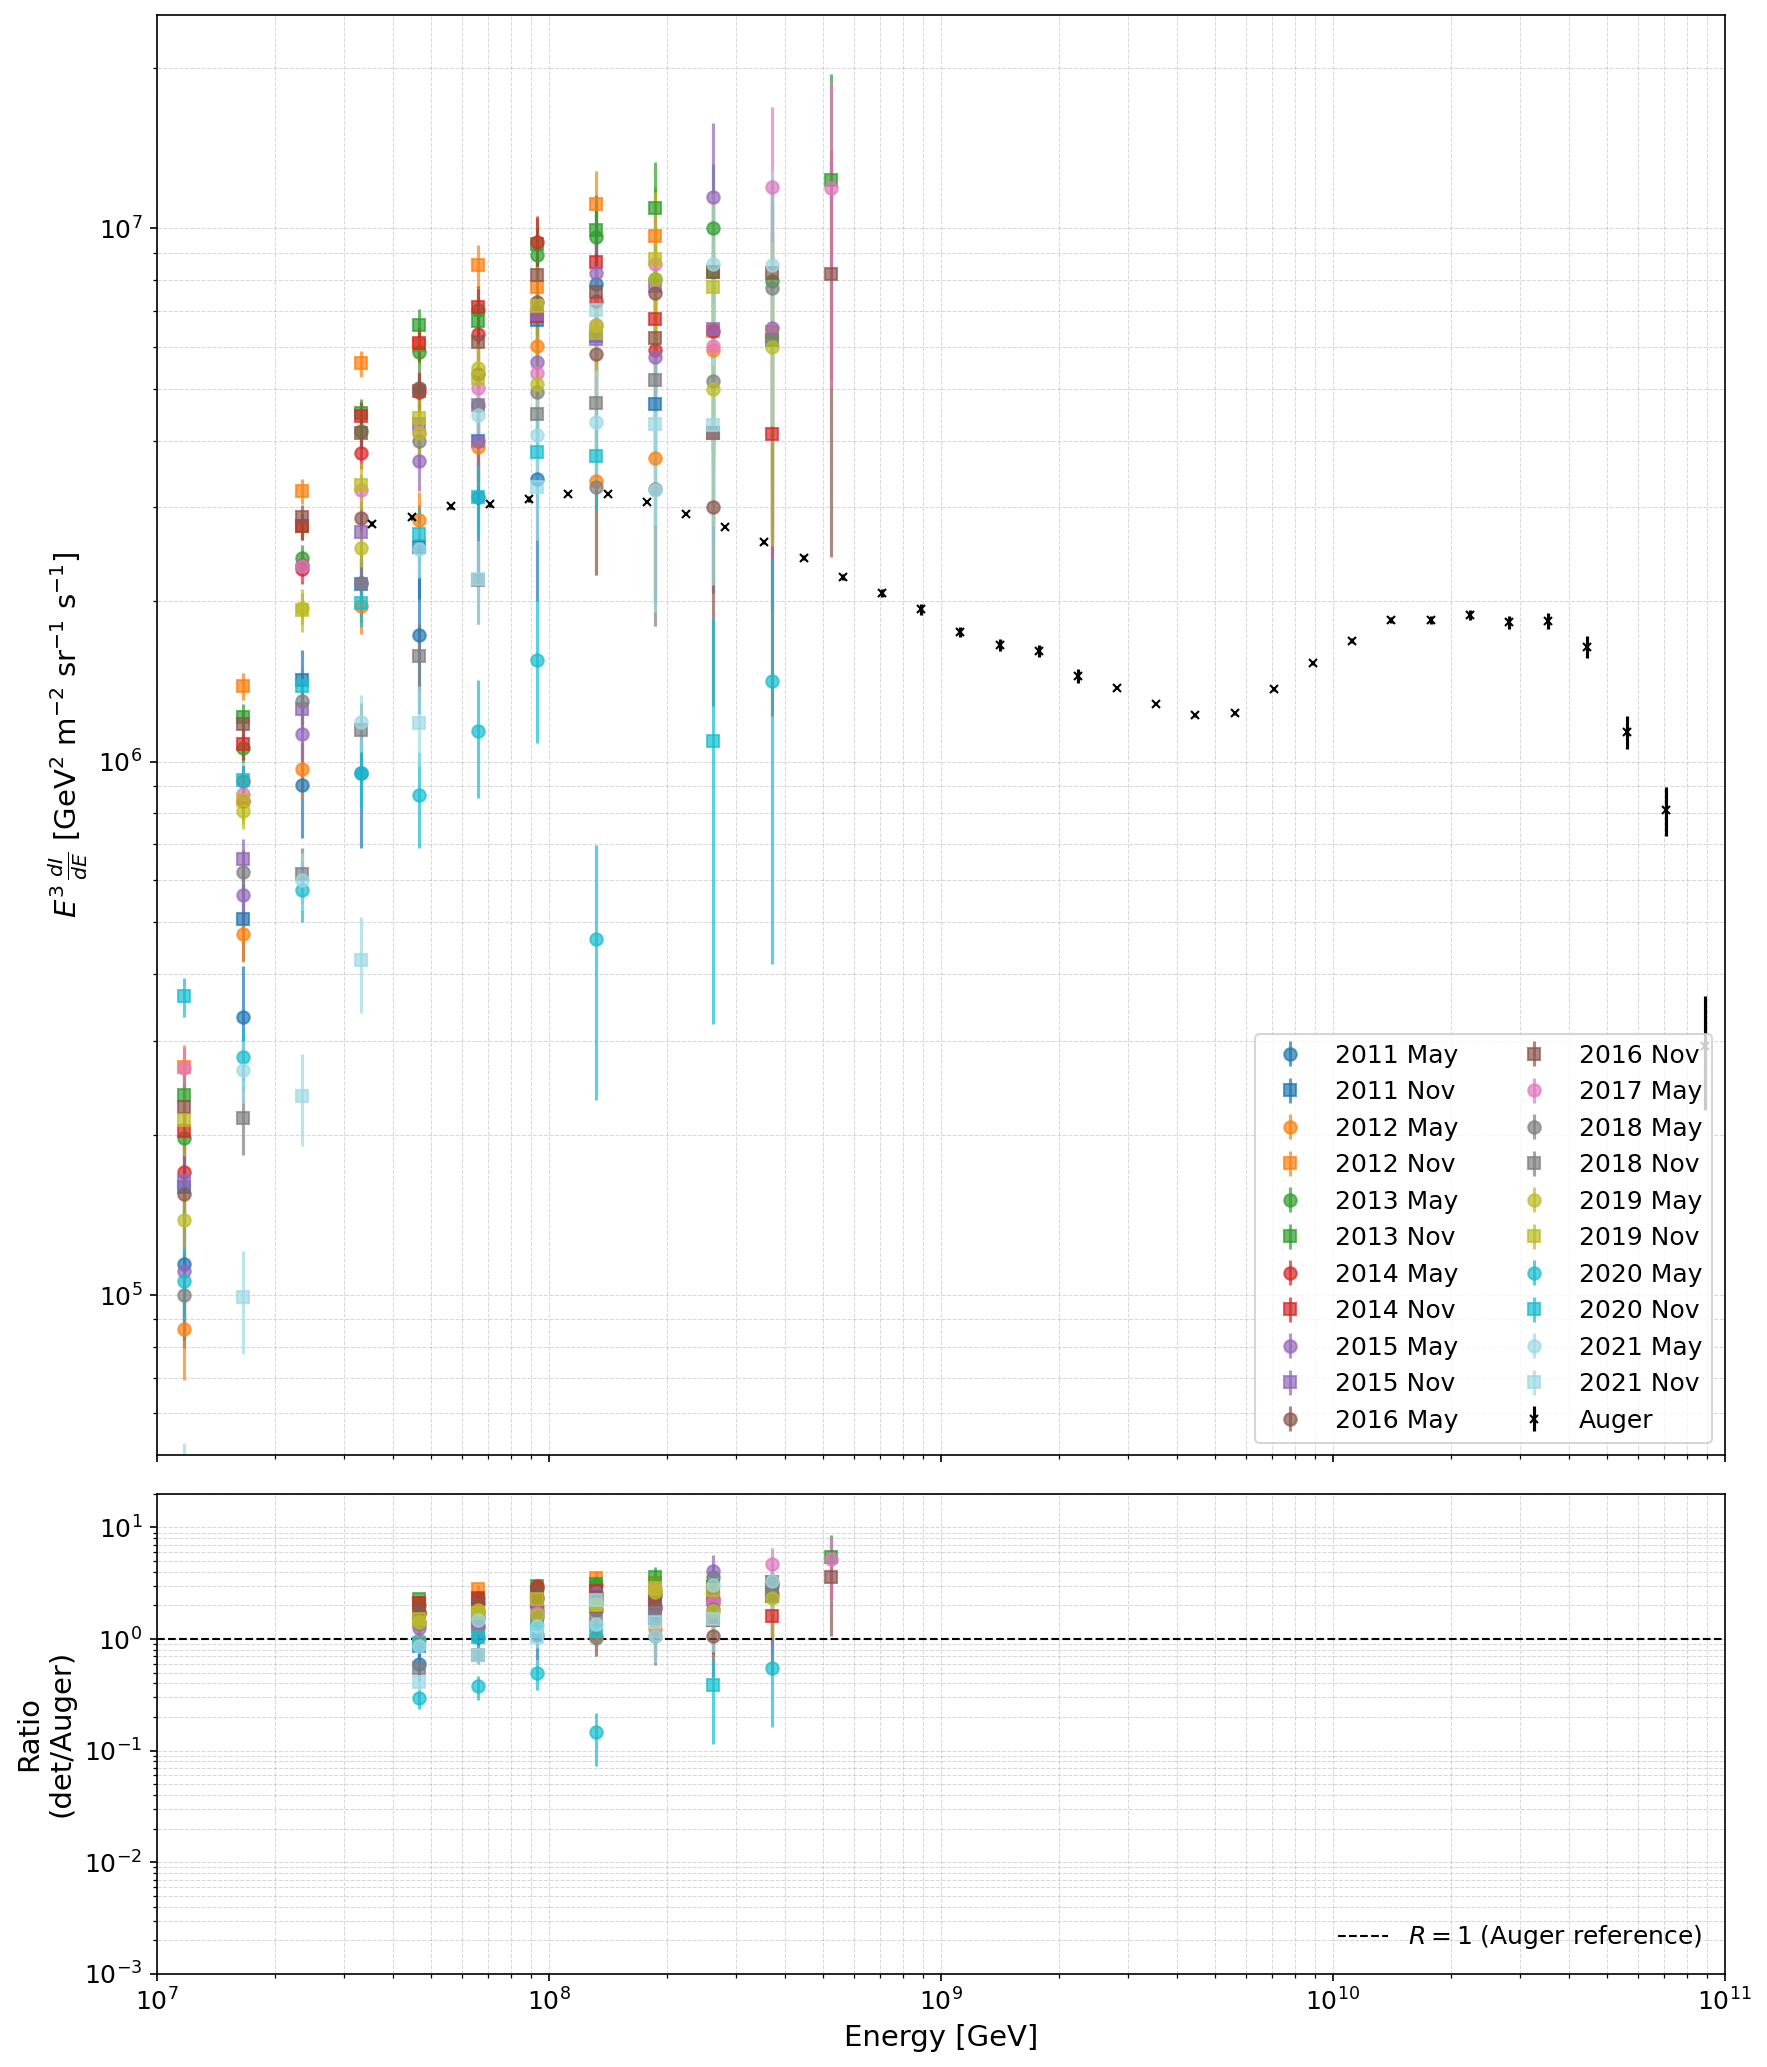

In [ ]:
"""
Comparison of LORA data with Auger: auger_ratio.py

This script compares reconstructed cosmic ray energy spectra from LORA
(LOFAR Radboud Air Shower Array) measurements with the reference spectrum
from the Pierre Auger Observatory.

Workflow:
1. Load Auger reference flux data using NuRadioReco utilities and convert it 
   to GeV and GeV² units for direct comparison.
2. Define LORA detector acceptance (m²·sr) as a function of energy. 
   Acceptance values are taken from Dr. S. Thoudam’s paper:
   "Measurement of the cosmic-ray energy spectrum above 10^16 eV with the 
    LOFAR Radboud Air Shower Array."
3. Load yearly/monthly binned event data (2011–2021) containing:
   - Observation time (T_obs): from ROOT files
   - log10(E) bin centers: output of above code block
   - Event counts per bin: output of above code block
   - Statistical uncertainties: output of above code block
4. For each dataset:
   - Convert log10(E) bin centers into eV energies and compute bin widths.
   - Calculate differential flux dI/dE = counts / (ΔE · acceptance · T_obs).
   - Scale to E³ dI/dE for spectrum visualization in eV² (converted to GeV²).
5. Plot two panels:
   - Top: LORA spectra for May and November of each year compared with Auger.
   - Bottom: Ratio (LORA / Auger) per bin, with propagated uncertainties.
6. Print a summary table of bin-averaged ratios (⟨R⟩), their spread σ(R), 
   statistical uncertainty δR(stat), and number of contributing bins.

Key outputs:
- Spectra overlay: LORA (per year/month) vs. Auger reference.
- Ratio plots to assess consistency and systematic offsets.
- Tabulated summary of average ratios with statistical errors.

"""

import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities import cr_flux, units
#1) Load and convert Auger reference to GeV & GeV^2 units
energies_A, fluxes_A, _, fluxes_A_err = cr_flux.get_measured_data()
E_A_GeV     = energies_A / units.eV / 1e9
S_A_GeV2    = (energies_A**3 * fluxes_A)     / (units.eV**2/units.m**2/units.steradian/units.s) / 1e18
S_A_err_GeV2= (energies_A**3 * fluxes_A_err) / (units.eV**2/units.m**2/units.steradian/units.s) / 1e18

# 2) Detector acceptance (m²·sr)
# Energy-dependent detector acceptance (m²·sr) for each bin center
A_acc = np.array([
    63385.0, 67025.0, 69462.5, 71150.0, 72282.5, 72965.0, 73452.5,
    73820.0, 74105.0, 74315.0, 74427.5, 74510.0, 74567.5, 74590.0,
    74515.0, 74440.0, 74330.0, 74175.0, 73987.5, 73770.0
])


# Define bin centers and counts with uncertainties for both months

data_2011 = {
    "May": {
    "T_obs": 604800,
     "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([11, 17, 24, 13, 12, 11, 6, 7, 0, 1, 0, 0, 0, 0]),
    "errors": np.array([3.32, 4.12, 4.90, 3.61, 3.46, 3.32, 2.45, 2.65, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00])
},
"Nov": {
    "T_obs": 864000,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([22, 37, 54, 42, 25, 20, 17, 8, 3, 1, 0, 0, 1, 0]),
    "errors": np.array([4.69, 6.08, 7.35, 6.48, 5.00, 4.47, 4.12, 2.83, 1.73, 1.00, 0.00, 0.00, 1.00, 0.00])
}
}
data_2012 ={
    "May": {
    "T_obs": 1814400,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([25, 73, 77, 80, 59, 41, 32, 9, 5, 4, 1, 0, 0, 0]),
    "errors": np.array([5.00, 8.54, 8.77, 8.94, 7.68, 6.40, 5.66, 3.00, 2.24, 2.00, 1.00, 0.00, 0.00, 0.00])
}

,
"Nov": {
    "T_obs": 2505600,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([107, 293, 353, 315, 174, 124, 57, 41, 18, 6, 3, 1, 0, 0]),
    "errors": np.array([10.34, 17.12, 18.79, 17.75, 13.19, 11.14, 7.55, 6.40, 4.24, 2.45, 1.73, 1.00, 0.00, 0.00])
}
}
data_2013 ={
    "May": {
    "T_obs": 2678400,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02, 18.17, 18.32, 18.47, 18.62, 18.77, 18.92]),
    "counts": np.array([84, 240, 283, 252, 180, 109, 70, 38, 16, 10, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
    "errors": np.array([9.17, 15.49, 16.82, 15.87, 13.42, 10.44, 8.37, 6.16, 4.00, 3.16, 2.00, 1.00, 1.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00])
}
,
"Nov": {
    "T_obs": 2592000,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([98, 265, 314, 263, 196, 101, 71, 38, 21, 8, 3, 3, 0, 0]),
    "errors": np.array([9.90, 16.28, 17.72, 16.22, 14.00, 10.05, 8.43, 6.16, 4.58, 2.83, 1.73, 1.73, 0.00, 0.00])
}


}
data_2014 ={
    "May": {
    "T_obs": 2505600,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([68, 179, 253, 214, 142, 92, 69, 27, 11, 6, 0, 1, 0, 0]),
    "errors": np.array([8.25, 13.38, 15.91, 14.63, 11.92, 9.59, 8.31, 5.20, 3.32, 2.45, 0.00, 1.00, 0.00, 0.00])
},
"Nov": {
    "T_obs": 2592000,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([84, 236, 314, 260, 181, 107, 52, 33, 13, 4, 2, 1, 0, 0]),
    "errors": np.array([9.17, 15.36, 17.72, 16.12, 13.45, 10.34, 7.21, 5.74, 3.61, 2.00, 1.41, 1.00, 0.00, 0.00])
}

}
data_2015 = {
    "May": {
    "T_obs": 1641600,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([29, 78, 81, 80, 69, 38, 27, 20, 7, 7, 2, 0, 0, 0]),
    "errors": np.array([5.39, 8.83, 9.00, 8.94, 8.31, 6.16, 5.20, 4.47, 2.65, 2.65, 1.41, 0.00, 0.00, 0.00])
}
,
"Nov":{
    "T_obs": 2073600,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([54, 115, 114, 126, 102, 56, 42, 19, 12, 5, 0, 1, 0, 0]),
    "errors": np.array([7.35, 10.72, 10.68, 11.22, 10.10, 7.48, 6.48, 4.36, 3.46, 2.24, 0.00, 1.00, 0.00, 0.00])
}


}
data_2016 = {
    "May": {
    "T_obs": 2678400,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([66, 208, 275, 173, 154, 83, 57, 23, 15, 3, 1, 0, 1, 0]),
    "errors": np.array([8.12, 14.42, 16.58, 13.15, 12.41, 9.11, 7.55, 4.80, 3.87, 1.73, 1.00, 0.00, 1.00, 0.00])
}
,
"Nov": {
    "T_obs": 2592000,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([93, 258, 327, 241, 147, 92, 62, 29, 12, 8, 4, 2, 0, 0]),
    "errors": np.array([9.64, 16.06, 18.08, 15.52, 12.12, 9.59, 7.87, 5.39, 3.46, 2.83, 2.00, 1.41, 0.00, 0.00])
}


}
data_2017= {
    "May": {
    "T_obs": 2678400,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([114, 197, 274, 195, 127, 78, 42, 26, 17, 6, 6, 3, 1, 0]),
    "errors": np.array([10.68, 14.04, 16.55, 13.96, 11.27, 8.83, 6.48, 5.10, 4.12, 2.45, 2.45, 1.73, 1.00, 0.00])
}


}

data_2018 = {
    "May": {
    "T_obs": 2073600,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([33, 109, 118, 101, 95, 56, 30, 10, 5, 4, 3, 0, 0, 0]),
    "errors": np.array([5.74, 10.44, 10.86, 10.05, 9.75, 7.48, 5.48, 3.16, 2.24, 2.00, 1.73, 0.00, 0.00, 0.00])
}
,
    "Nov": {
    "T_obs": 2592000,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([16, 47, 70, 67, 47, 33, 34, 18, 10, 4, 3, 0, 1, 0]),
    "errors": np.array([4.00, 6.86, 8.37, 8.19, 6.86, 5.74, 5.83, 4.24, 3.16, 2.00, 1.73, 0.00, 1.00, 0.00])
}

}

data_2019 ={
    "May": {
    "T_obs": 2678400,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02, 18.17, 18.32, 18.47, 18.62, 18.77, 18.92]),
    "counts": np.array([59, 183, 228, 152, 127, 85, 40, 26, 16, 5, 3, 1, 1, 0, 0, 1, 0, 0, 0, 0]),
    "errors": np.array([7.68, 13.53, 15.10, 12.33, 11.27, 9.22, 6.32, 5.10, 4.00, 2.24, 1.73, 1.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00])
},
"Nov": {
    "T_obs": 1382400,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([47, 99, 117, 103, 70, 42, 29, 13, 9, 4, 1, 1, 0, 0]),
    "errors": np.array([6.86, 9.95, 10.82, 10.15, 8.37, 6.48, 5.39, 3.61, 3.00, 2.00, 1.00, 1.00, 0.00, 0.00])
}
}

data_2020 = {
    "May": {
    "T_obs": 2419200,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([41, 57, 61, 52, 24, 16, 11, 4, 0, 0, 2, 0, 0, 0]),
    "errors": np.array([6.40, 7.55, 7.81, 7.21, 4.90, 4.00, 3.32, 2.00, 0.00, 0.00, 1.41, 0.00, 0.00, 0.00])
}
,
"Nov": {
    "T_obs": 2419200,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([140, 189, 147, 108, 74, 44, 27, 22, 1, 2, 1, 1, 0, 0]),
    "errors": np.array([11.83, 13.75, 12.12, 10.39, 8.60, 6.63, 5.20, 4.69, 1.00, 1.41, 1.00, 1.00, 0.00, 0.00])
}


}

data_2021 = {
    "May":{
    "T_obs": 2505600,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([17, 56, 66, 67, 72, 65, 30, 16, 6, 8, 4, 1, 1, 0]),
    "errors": np.array([4.12, 7.48, 8.12, 8.19, 8.49, 8.06, 5.48, 4.00, 2.45, 2.83, 2.00, 1.00, 1.00, 0.00])
}

,

"Nov": {
    "T_obs": 2505600,
    "bin_centers": np.array([16.07, 16.22, 16.37, 16.52, 16.67, 16.82, 16.97, 17.12, 17.27, 17.42, 17.57, 17.72, 17.87, 18.02]),
    "counts": np.array([7, 21, 26, 24, 34, 32, 24, 26, 8, 4, 1, 1, 0, 0]),
    "errors": np.array([2.65, 4.58, 5.10, 4.90, 5.83, 5.66, 4.90, 5.10, 2.83, 2.00, 1.00, 1.00, 0.00, 0.00])
}
    
}

# Collect them into one big dict:
all_data = {
    2011: data_2011,
    2012: data_2012,
    2013: data_2013,
    2014: data_2014,
    2015: data_2015,
    2016: data_2016,
    2017: data_2017,
    2018: data_2018,
    2019: data_2019,
    2020: data_2020,
    2021: data_2021
}

# Spectrum calculator
def calculate_spectrum(bin_centers, counts, errors, T_obs, count_threshold=1):
    mask = counts > count_threshold
    bc = bin_centers[mask]
    c  = counts[mask]
    e  = errors[mask]
    acc = A_acc[:len(bin_centers)][mask]

    # Energy in eV
    E_eV      = 10**bc
    # Compute bin edges in eV
    log_edges = np.concatenate((
        [bc[0] - (bc[1] - bc[0]) / 2],
        (bc[:-1] + bc[1:]) / 2,
        [bc[-1] + (bc[-1] - bc[-2]) / 2]
    ))
    E_edges = 10**log_edges
    widths  = np.diff(E_edges)

    # Differential flux
    dI_dE     = c / (widths * acc * T_obs)
    dI_dE_err = e / (widths * acc * T_obs)

    # E^3 dI/dE in eV^2 units
    E3_dI     = E_eV**3 * dI_dE
    E3_dI_err = E_eV**3 * dI_dE_err

    return E_eV, E3_dI, E3_dI_err, E_edges

# Fetch and convert Auger reference
ergies_A, fluxes_A, _, fluxes_A_err = cr_flux.get_measured_data()
E_A     = energies_A / units.eV  # in eV
S_A     = E_A**3 * fluxes_A     / (units.eV**2/units.m**2/units.steradian/units.s)
S_A_err = E_A**3 * fluxes_A_err / (units.eV**2/units.m**2/units.steradian/units.s)

# Plot setup
fig, (ax_spec, ax_ratio) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    gridspec_kw={"height_ratios":[3,1]},
    figsize=(12,14)
)
years  = range(2011, 2022)
colors = plt.cm.tab20(np.linspace(0,1,len(years)))
summary = []  # (year, month, mean_R, std_R, mean_stat_err, N)

# Top panel: raw spectra in GeV^2 units
for i, year in enumerate(years):
    for month, marker in zip(["May","Nov"], ["o","s"]):
        d = all_data.get(year,{}).get(month)
        if not d: continue

        E_eV, S_eV2, S_err_eV2, _ = calculate_spectrum(
            d["bin_centers"], d["counts"], d["errors"], d["T_obs"]
        )
        E_GeV      = E_eV / 1e9
        # Convert eV^2 -> GeV^2: divide by (1e9)^2 = 1e18
        S_GeV2     = S_eV2    / 1e18
        S_err_GeV2 = S_err_eV2/ 1e18

        ax_spec.errorbar(
            E_GeV, S_GeV2, yerr=S_err_GeV2,
            fmt=marker, color=colors[i], alpha=0.7, label=f"{year} {month}"
        )

# Auger reference in GeV^2 units
ax_spec.errorbar(
    E_A/1e9, S_A/1e18, yerr=S_A_err/1e18,
    fmt='x', color='k', label='Auger', markersize=4
)

ax_spec.set_xscale("log")
ax_spec.set_yscale("log")
ax_spec.set_ylabel(r"$E^3\,\frac{dI}{dE}$ [GeV$^2$ m$^{-2}$ sr$^{-1}$ s$^{-1}$]", fontsize=14)
ax_spec.set_ylim(10**4.7, 10**7.4)
#ax_spec.set_title("Cosmic Ray Energy Spectra from 2011-2021 (May & Nov)", fontsize=14)
ax_spec.legend(fontsize=12, ncol=2, loc="lower right")
ax_spec.grid(which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.3)


# Bottom panel: bin-averaged ratio
for i, year in enumerate(years):
    for month, marker in zip(["May", "Nov"], ["o", "s"]):
        d = all_data.get(year, {}).get(month)
        if not d:
            continue

        E_eV, S_eV2, S_err_eV2, E_edges = calculate_spectrum(
            d["bin_centers"], d["counts"], d["errors"], d["T_obs"]
        )

        # Use the same bin centers as top plot
        mid_E_eV = E_eV
        E_GeV    = E_eV / 1e9

        # Mask to keep only bins within Auger energy range
        valid = (mid_E_eV >= E_A.min()) & (mid_E_eV <= E_A.max())
        if not np.any(valid):
            continue

        mid_E_eV  = mid_E_eV[valid]
        E_GeV     = E_GeV[valid]
        S_eV2     = S_eV2[valid]
        S_err_eV2 = S_err_eV2[valid]

        # Interpolate Auger data at matching energies
        S_A_bin     = np.interp(mid_E_eV, E_A, S_A)
        S_A_err_bin = np.interp(mid_E_eV, E_A, S_A_err)

        # Ratio (conversion cancels)
        R     = (S_eV2 / 1e18) / (S_A_bin / 1e18)
        R_err = R * np.sqrt((S_err_eV2 / S_eV2)**2 +
                            (S_A_err_bin / S_A_bin)**2)

        summary.append((year, month, np.mean(R), np.std(R), np.mean(R_err), len(R)))

        ax_ratio.errorbar(
            E_GeV, R, yerr=R_err,
            fmt=marker, color=colors[i], alpha=0.7
        )



ax_ratio.axhline(1.0, color='black', ls='--', lw=1, label=r"$R = 1$ (Auger reference)")
ax_ratio.set_xscale("log")
ax_ratio.set_yscale("log")
ax_ratio.set_xlabel("Energy [GeV]", fontsize=14)
ax_ratio.set_ylabel("Ratio\n(det/Auger)", fontsize=14)
ax_ratio.set_ylim(0.001, 20)
ax_ratio.legend(loc="lower right", fontsize=12, frameon=False)
# Increase tick font sizes for both plots
for ax in [ax_spec, ax_ratio]:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)

# Set (zoomed in) x-limits in GeV
#ax_spec.set_xlim((E_A.min() / 1e9) * 0.7, 1e9)
#ax_ratio.set_xlim((E_A.min() / 1e9) * 0.7, 1e9)

# Set x-limits in GeV
ax_spec.set_xlim(1e7, 1e11)
ax_ratio.set_xlim(1e7, 1e11)


ax_ratio.grid(which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()



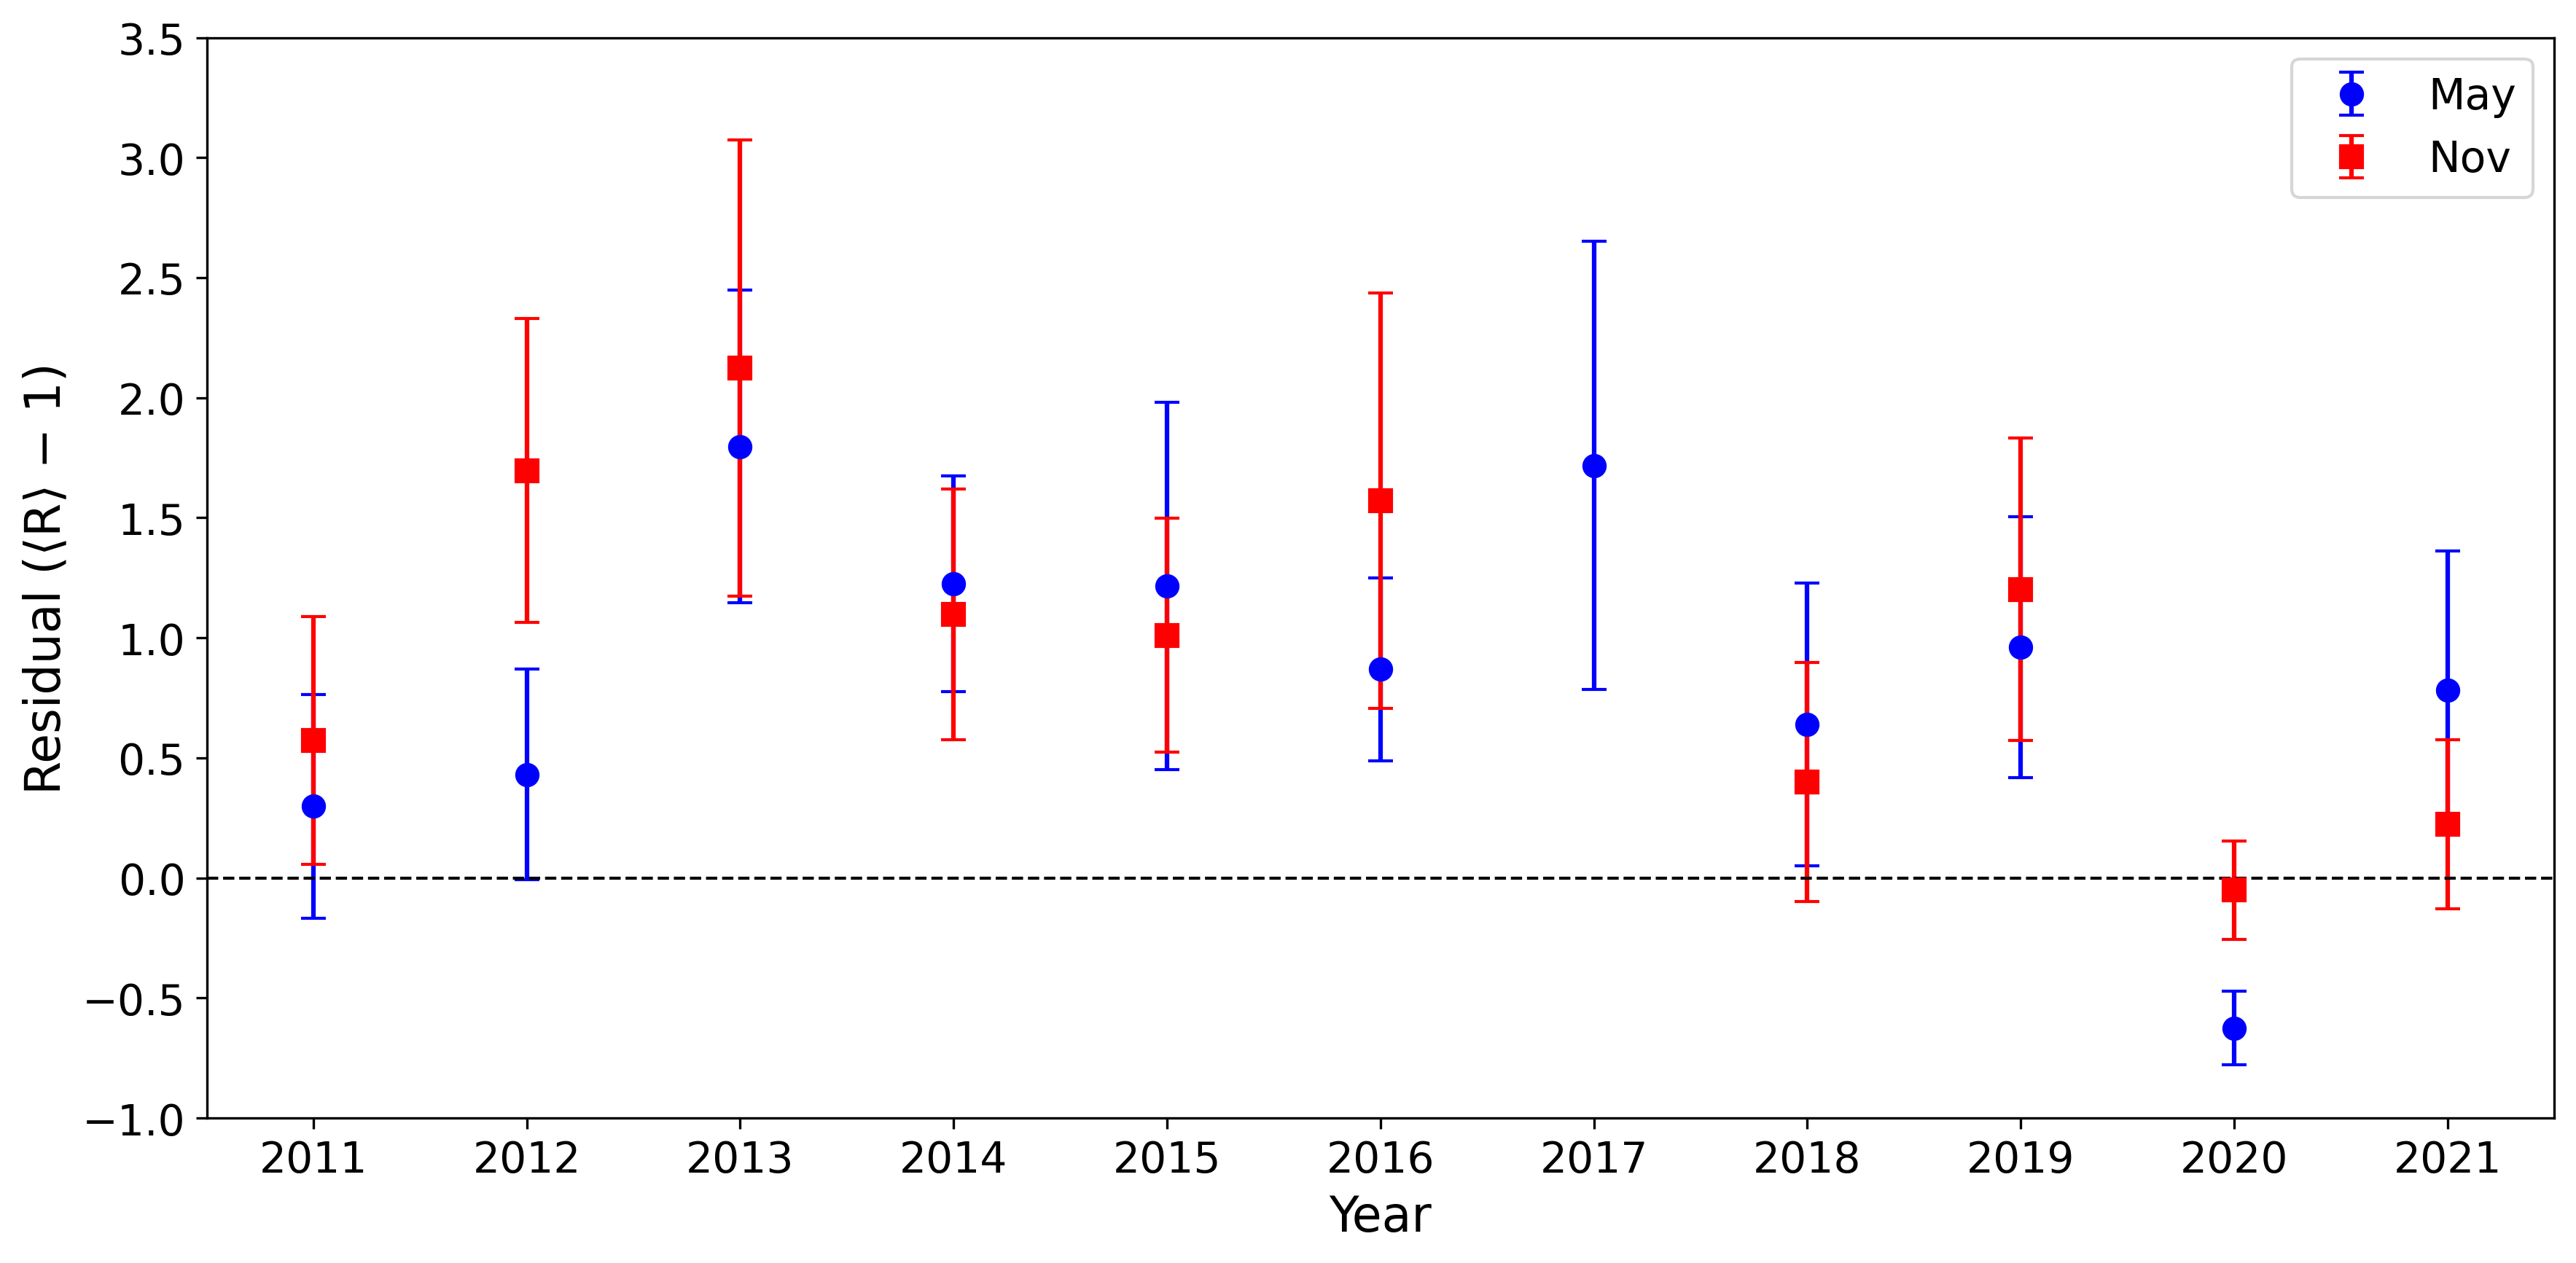

In [5]:
"""
This script visualizes the temporal stability of the LORA-to-Auger flux ratio
by plotting residuals (⟨R⟩ − 1) with statistical uncertainties for May and
November datasets across the years 2011–2021.

Workflow:
1. Define input arrays:
   - Years and corresponding months of observation.
   - Average ratio ⟨R⟩ = (LORA / Auger) per dataset.
   - Statistical uncertainties δR(stat).
2. Compute residuals relative to unity (⟨R⟩ − 1).
3. Plot residuals vs. year for May and November separately, using distinct
   markers and colors:
   - Blue circles for May.
   - Red squares for November.
   - Error bars represent δR(stat).
4. Add reference line at zero residual, axis labels, legend, and year ticks.
5. Display final high-resolution plot for visual comparison.

Key output:
- Residual stability plot showing whether the LORA/Auger ratio is consistently
  above/below unity and how it evolves over time, separated by season (May/Nov).
"""


# Years and months
years  = [2011,2011,2012,2012,2013,2013,2014,2014,2015,2015,
          2016,2016,2017,2018,2018,2019,2019,2020,2020,2021,2021]
months = ["May","Nov","May","Nov","May","Nov","May","Nov","May","Nov",
          "May","Nov","May","May","Nov","May","Nov","May","Nov","May","Nov"]

# Updated Auger-ratio summary (⟨R⟩ and δR(stat))
R_mean = [1.298,1.573,1.431,2.697,2.797,3.124,2.225,2.098,2.215,2.011,
          1.869,2.571,2.718,1.639,1.400,1.961,2.202,0.375,0.950,1.782,1.224]
R_stat = [0.466,0.516,0.438,0.632,0.652,0.949,0.449,0.523,0.765,0.486,
          0.381,0.865,0.934,0.588,0.497,0.544,0.630,0.154,0.205,0.579,0.352]

# Compute residuals (relative to 1)
residuals = np.array(R_mean) - 1

# Plot with high resolution
fig, ax = plt.subplots(figsize=(12,6), dpi=300)

for month, marker, color in zip(["May","Nov"], ["o","s"], ["blue","red"]):
    mask = np.array(months) == month
    ax.errorbar(
        np.array(years)[mask],
        residuals[mask],
        yerr=np.array(R_stat)[mask],
        fmt=marker,
        markersize=7,
        elinewidth=1.5,
        capsize=4,
        color=color,
        label=month
    )

# Formatting
ax.axhline(0, color='k', ls='--', lw=1)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Residual (⟨R⟩ − 1)", fontsize=16)

ax.set_xticks(np.arange(min(years), max(years)+1, 1))  # show all years
ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14)
ax.set_ylim(-1, 3.5)

plt.tight_layout()
plt.show()
